In [1]:
# Importing necessary libraries
!pip install langid
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, lower, regexp_replace, split, udf
from pyspark.sql.types import StringType, IntegerType 
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
import numpy as np
import langid
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.sql.functions import col, udf
from pyspark.sql.functions import col, udf
from pyspark.ml.linalg import DenseVector, SparseVector, VectorUDT
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

  Using cached langid-1.1.6-py3-none-any.whl


In [2]:
# Create Spark session
spark = SparkSession.builder \
    .config("spark.sql.shuffle.partitions", 10) \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.executor.heartbeatInterval", "100000s") \
    .config("spark.network.timeout", "10000000s") \
    .master("local[*]") \
    .appName("Project 3") \
    .getOrCreate()

## Reading data

In [3]:
# !unzip -u dblp.v10.zip

In [4]:
# from functools import reduce
# file_paths = ["./dblp-ref/dblp-ref-0.json", "./dblp-ref/dblp-ref-1.json", "./dblp-ref/dblp-ref-2.json", "./dblp-ref/dblp-ref-3.json"]
# dfs = [spark.read.json(file_path) for file_path in file_paths]
# df = reduce(lambda df1, df2: df1.union(df2), dfs)
# df.show(5)

# test with single dataset
df = spark.read.json("./dblp-ref/dblp-ref-0.json")

# df = df.limit(1000)

## Understanding data

In [5]:
df.printSchema()
total_records = df.count()
# print("Total number of records:", total_records)

df.show(5)
print(f"Number of records: {df.count()}")

root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- n_citation: long (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- year: long (nullable = true)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|
|This paper descri...

In [6]:
# df.describe().show()
df.describe().toPandas()
# Check for missing values (excluding `isnan`)
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()
df.select("n_citation").describe().show()
df.filter(df.abstract.isNull() | df.title.isNull()).show()

+--------+-------+---+----------+----------+-----+-----+----+
|abstract|authors| id|n_citation|references|title|venue|year|
+--------+-------+---+----------+----------+-----+-----+----+
|  246354|      0|  0|         0|    138520|    0|    0|   0|
+--------+-------+---+----------+----------+-----+-----+----+

+-------+------------------+
|summary|        n_citation|
+-------+------------------+
|  count|           1000000|
|   mean|          30.87573|
| stddev|137.94247310778852|
|    min|                 0|
|    max|             73362|
+-------+------------------+

+--------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|    NULL|[Jea-Bum Park, By...|

### Preprocessing

In [7]:
# Filter only English documents
def detect_language(text):
    if text is None:
        return None
    lang, _ = langid.classify(text)
    return lang

# Registering UDF
lang_detect_udf = udf(detect_language, StringType())
df = df.withColumn("language", lang_detect_udf(df.abstract))
df = df.filter(df.language == 'en')
df.show()

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|language|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|      en|
|This paper descri...|[Gareth Beale, Gr...|001c58d3-26ad-46b...|        50|[10482dd3-4642-41...|A methodology for...|visual analytics ...|2011|      en|
|This article appl...|[Altaf Hossain, F...|001c8744-73c4-4b0...|        50|[2d84c0f2-e656-4c...|Comparison of GAR...|pattern recogniti...|2009|      en|
|Recent achievemen...|[Ankita Brahmacha...|00a119c4-d367-460...|         0|[84d471

In [8]:
# Lowercase and remove punctuation
df_cleaned = df.withColumn("cleaned_abstract", lower(col("abstract")))
df_cleaned = df_cleaned.withColumn("cleaned_abstract", regexp_replace(col("cleaned_abstract"), r'[!()\-\[\]{};:\'",<>./?@#$%^&*_~]', ''))

In [9]:
# Tokenize the text
tokenizer = Tokenizer(inputCol="cleaned_abstract", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

In [10]:
# Remove stop words
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=StopWordsRemover().getStopWords() + custom_stop_words)
df_filtered = remover.transform(df_tokenized)

In [11]:
# print(df_filtered.count())

### Vectorization

In [12]:
# Train a Word2Vec model
word2vec = Word2Vec(vectorSize=10, minCount=1, inputCol="filtered_words", outputCol="word2vec_features")
model = word2vec.fit(df_filtered)
df_vectorized = model.transform(df_filtered)

In [13]:
# Selecting features column we use later
df_vectorized = df_vectorized.select("id", "venue", "word2vec_features")

In [14]:
# Define UDF for converting sparse to dense vectors
def to_dense(v):
    if isinstance(v, SparseVector):
        return DenseVector(v.toArray())
    elif isinstance(v, DenseVector):
        return v
    else:
        raise TypeError("Unsupported vector type")

to_dense_udf = udf(to_dense, VectorUDT())
# Apply UDF to convert features to dense vectors and extract feature column
df_dense = df_vectorized.withColumn('dense_features', to_dense_udf(col('word2vec_features')))
df_dense = df_dense.select("id", "venue", "dense_features")
# Convert the Spark DataFrame to Pandas DataFrame
df_dense_pd = df_dense.toPandas()
# print(df_dense_pd)
features = np.array(df_dense_pd['dense_features'].tolist())

In [15]:
### Clustering

In [16]:
# Standardize the data for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
print(scaled_data)
# Apply PCA to reduce dimensions while keeping 95% of the variance
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(scaled_data)
print(reduced_data)

[[-1.27517674 -0.61106078  0.79861785 ...  0.48614473  0.89576689
  -1.61576559]
 [-0.66453645  0.3452374  -0.31706128 ... -0.45090572  0.28935305
  -0.85152725]
 [ 0.13816818 -0.26683364 -1.32227631 ... -0.50527249 -0.67242308
  -0.24421716]
 ...
 [-0.37333109  1.04229886  0.83090602 ... -0.48765502 -1.37753142
   0.97029149]
 [-0.57732307  0.23797441  1.11598353 ...  0.26297721  0.41898768
  -0.28038966]
 [ 0.78188538 -1.73696919  0.02797648 ... -0.21024237 -0.07454211
   0.29329405]]
[[-2.22407608  1.41230272 -0.53990113 ... -0.3812318  -0.73860664
  -1.22366245]
 [-0.73456492  0.3840362  -0.82617304 ... -0.25608024 -0.52309944
   0.05386288]
 [ 0.2749731  -1.25851938 -1.73742204 ...  0.21496993 -1.51617702
  -1.63672292]
 ...
 [ 0.19836341 -1.65355575  0.42662786 ... -1.24518069  0.77634595
   0.37865596]
 [-1.25073748  0.14459015 -0.13341126 ... -0.30408336  0.7871494
  -0.17648199]
 [ 1.9964432   2.09434559  0.02662322 ... -0.20174455  0.42826423
  -0.32043759]]


## Ploting 

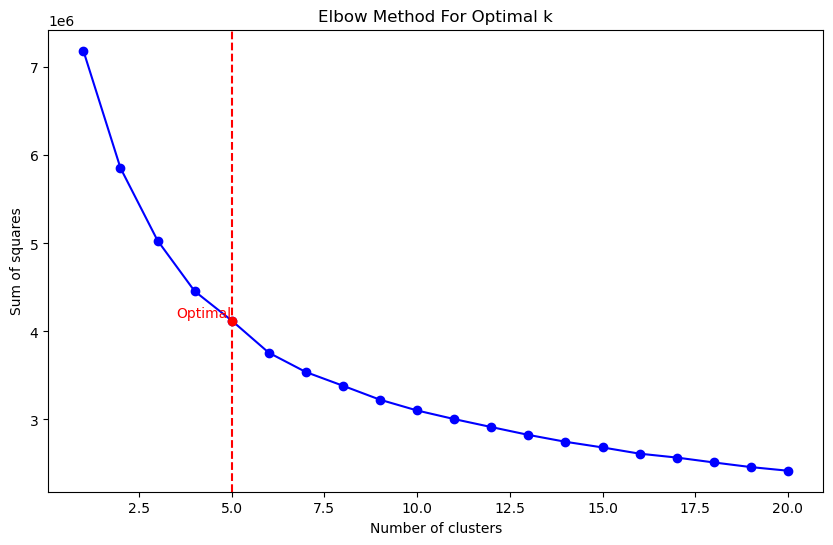

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(reduced_data)
    wcss.append(kmeans.inertia_)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, 'bo-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares')

# Finding the elbow point
def find_elbow(wcss):
    differences = np.diff(wcss)
    second_differences = np.diff(differences)
    optimal_index = np.argmin(second_differences) + 2
    return optimal_index

optimal_k = find_elbow(wcss)
plt.axvline(x=optimal_k, color='r', linestyle='--')
plt.plot(optimal_k, wcss[optimal_k-1], 'ro')
plt.text(optimal_k, wcss[optimal_k-1], 'Optimal', horizontalalignment='right', verticalalignment='bottom', color='r')
# plt.show()

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(reduced_data)
df_dense_pd['Cluster'] = clusters
# print(df_dense_pd.head())


## Recommendation 

In [18]:
# Recommending papers
def recommend_papers(input_title, N):
    # Vectorize the input title using the Word2Vec model
    input_vector = model.transform(spark.createDataFrame([(input_title.split(),)], ["filtered_words"])).select("word2vec_features").collect()[0][0]
    input_vector = np.array(input_vector).reshape(1, -1)
    
    # Predict the cluster for the input title
    cluster_label = km_model.predict(input_vector)[0]
    
    # Get indices of papers in the same cluster
    cluster_indices = df_vectorized.filter(df_vectorized['id'] == cluster_label).select("id").collect()
    
    # Compute cosine similarities
    cluster_indices = [index["id"] for index in cluster_indices]
    similarities = cosine_similarity(input_vector, word2vec_features[cluster_indices].reshape(-1, word2vec_features.shape[-1])).flatten()
    
    # Get top N similar papers
    similar_indices = np.argsort(similarities)[-N:][::-1]

    recommended_papers = [cluster_paper_titles[i] for i in similar_indices]
    return recommended_papers
# Example usage
input_title = "Deep Learning for Natural Language Processing"
N = 3
recommended_papers = recommend_papers("Urban", N)
# print("Recommended papers:")
# for paper in recommended_papers:
#     print(paper)


NameError: name 'km_model' is not defined